# 暂退法（Dropout）

### 练习 1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

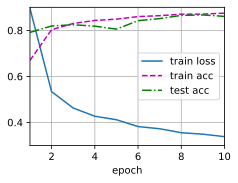

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, dropout1, dropout2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        self.dropout1 = dropout1
        self.dropout2 = dropout2

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout2)
        out = self.lin3(H2)
        return out

def train_net(dropout1, dropout2):
    net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, dropout1, dropout2)
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
    return net

# 原始暂退概率
dropout1, dropout2 = 0.2, 0.5
net_original = train_net(dropout1, dropout2)

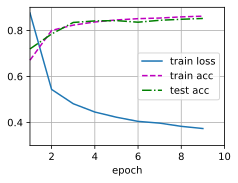

In [ ]:
# 交换暂退概率
net_swapped = train_net(dropout2, dropout1)

## 练习2 增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。

In [ ]:
# 定义训练函数
def train_net(dropout1, dropout2, num_epochs, is_training=True):
    net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, dropout1, dropout2, is_training)
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
    return net

In [ ]:
# 使用暂退法
dropout1, dropout2 = 0.2, 0.5
num_epochs = 10
net_with_dropout = train_net(dropout1, dropout2, num_epochs)

In [ ]:
# 不使用暂退法，增加训练轮数
net_without_dropout = train_net(0, 0, num_epochs * 2, is_training=False)

## 练习3 当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。

In [ ]:
class VarNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, dropout1, dropout2):
        super(VarNet, self).__init__()
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.variances = {'h1': [], 'h2': []}

    def forward(self, X, record_var=False):
        H1 = self.relu(self.lin1(X.reshape((-1, num_inputs))))
        if self.dropout1 > 0:  # 应用dropout
            H1 = dropout_layer(H1, self.dropout1)
        if record_var:
            self.variances['h1'].append(H1.var().detach())
        H2 = self.relu(self.lin2(H1))
        if self.dropout2 > 0:  # 应用dropout
            H2 = dropout_layer(H2, self.dropout2)
        if record_var:
            self.variances['h2'].append(H2.var().detach())
        out = self.lin3(H2)
        return out


In [ ]:
def train_var_net(net, num_epochs):
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X, record_var=True)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
    return net

In [ ]:
# 使用暂退法
net_with_dropout = VarNet(num_inputs, num_outputs, num_hiddens1, num_hiddens2, 0.2, 0.5)
net_with_dropout = train_var_net(net_with_dropout, num_epochs)

In [ ]:
# 不使用暂退法
net_without_dropout = VarNet(num_inputs, num_outputs, num_hiddens1, num_hiddens2, 0, 0)
net_without_dropout = train_var_net(net_without_dropout, num_epochs)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, net_with_dropout.variances['h1'], label='Layer 1 Variance with Dropout')
plt.plot(epochs, net_with_dropout.variances['h2'], label='Layer 2 Variance with Dropout')
plt.plot(epochs, net_without_dropout.variances['h1'], label='Layer 1 Variance without Dropout', linestyle='dashed')
plt.plot(epochs, net_without_dropout.variances['h2'], label='Layer 2 Variance without Dropout', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.show()

## 练习4 为什么在测试时通常不使用暂退法？

在测试时通常不使用暂退法的原因主要归结于暂退法（Dropout）的设计目的和它在模型训练中的作用。

1. **防止过拟合**：暂退法主要用于防止神经网络在训练过程中的过拟合。它通过在训练时随机关闭一些神经元的输出来实现，这迫使网络学习更加健壮的特征表示。简而言之，暂退法使得模型不太可能依赖于训练数据集中的特定权重，增强了模型对数据的泛化能力。

2. **模型平均**：暂退法可以被视为一种训练时的模型平均。每次前向传播时，由于部分神经元的随机关闭，网络的结构都有所不同。这相当于训练了许多子网络。在测试时，我们希望利用所有这些学到的特征，因此不再进行随机关闭，而是使用完整的网络进行预测。

3. **保持一致性**：在测试时使用完整的网络可以保持模型结构的一致性。由于训练时一部分神经元被随机关闭，输出的期望值会减少。因此，在测试时，我们使用全部的神经元以保持输出的期望值与训练时相同。这通常通过在训练时对激活值进行缩放来实现（例如，在训练时使用了50%的暂退率，那么训练时的激活值会被放大一倍）。

4. **确定性输出**：测试模型时，我们期望对于同一输入总是得到相同的输出。使用暂退法会引入随机性，从而导致对同一输入可能产生不同的输出，这在测试和部署阶段是不可取的。

综上所述，暂退法是一种在训练阶段增加正则化、减少过拟合的技术，而在测试阶段我们希望利用所有训练好的特征，以及获得一致和确定的输出，因此不使用暂退法。

## 练习5 以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

### 暂退法（Dropout）

1. **目的**：暂退法主要用于减少神经网络训练过程中的过拟合。它通过在训练过程中随机关闭一部分神经元的输出，迫使网络不能依赖于任何一组特征，从而提高其泛化能力。

2. **效果**：暂退法增加了模型的鲁棒性，使得模型不易受到训练数据中的随机噪声或偏差的影响。

### 权重衰减（L2正则化）

1. **目的**：权重衰减是一种正则化技术，通过对模型的权重大小进行惩罚（通常是权重的平方和）来防止过拟合。这使得模型倾向于学习更小、更分散的权重。

2. **效果**：权重衰减限制了模型复杂度，减少了模型对单个数据点或特征的依赖，从而提高了模型的泛化能力。

### 同时使用暂退法和权重衰减

1. **组合效果**：同时使用暂退法和权重衰减可能会提供两种正则化技术的优势，增强模型的泛化能力。暂退法通过随机化训练过程增加了模型的鲁棒性，而权重衰减通过限制模型权重的大小减少了过拟合的风险。

2. **潜在问题**：虽然这种组合可能会提高模型的泛化能力，但也可能导致模型训练变得更加困难。如果正则化太强，可能会阻碍模型在训练数据上的学习，导致欠拟合。

3. **结果**：组合使用这两种技术的效果取决于具体的应用场景和数据集。在某些情况下，它们可能会相互补充，提供更好的性能；在其他情况下，过度的正则化可能导致性能下降。

### 总结

暂退法和权重衰减都是防止神经网络过拟合的有效技术。它们可以单独使用，也可以组合使用，以期望得到更好的正则化效果。然而，适当调整这两种技术的强度对于避免过度正则化和确保良好的模型性能至关重要。

## 练习6 如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？

将暂退法应用到权重矩阵的各个权重，而不是激活值，这种做法实际上会导致一个不同于传统暂退法的行为和效果。这种方法通常被称为**"DropConnect"**，它有一些独特的特点和影响：

### DropConnect

1. **原理**：在DropConnect中，而不是随机地将神经元的激活值设置为零（如在传统的Dropout中那样），而是随机地将权重矩阵中的某些权重设置为零。这意味着网络中的某些连接在每次前向传播时被随机地“删除”。

2. **效果**：与暂退法相似，DropConnect也引入了随机性，迫使网络不要过分依赖于任何特定的权重，从而增强了模型的泛化能力。它可以被视为更一般化的暂退法，因为它随机化的是权重而非激活值。

3. **与暂退法的区别**：在暂退法中，整个神经元及其所有输出连接都被随机“关闭”，而在DropConnect中，神经网络中的单个连接被随机断开。这使得DropConnect在理论上更加强大，因为它可以表示和模拟更广泛的网络结构。

4. **训练复杂度**：由于DropConnect随机化的是权重本身，这可能使得训练过程更加复杂。特别是在大型网络中，随机操作和更新巨大的权重矩阵可能会带来额外的计算负担。

5. **实际应用**：虽然DropConnect是一个有趣的概念，但在实际应用中，传统的暂退法由于其简单性和效率更为常见。DropConnect在某些特定的应用中可能会提供优势，但这需要针对具体情况进行调整和评估。

### 总结

将暂退法应用于权重矩阵是一种更一般化的正则化技术，它可以提供不同于传统暂退法的优势和挑战。虽然它在理论上可能更强大，但在实际应用中可能更复杂且计算成本更高。选择哪种技术取决于特定的应用场景和性能需求。

## 练习7 发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法。

发明一种新的随机噪声注入技术，不同于标准的暂退法，可以使用“**随机特征缩放（Random Feature Scaling, RFS）**”，这种方法可能在Fashion-MNIST数据集上提供与暂退法不同的优势。

### 随机特征缩放（Random Feature Scaling, RFS）

#### 原理
- 在每次训练迭代中，对于网络中的每一层（或选定层），随机选择一定比例的神经元，并将这些神经元的激活值乘以一个随机因子（大于0小于1的随机数）。这种方法类似于对神经元的激活值进行随机缩放。
- 与暂退法随机“关闭”神经元不同，RFS通过随机缩小部分神经元的输出影响力来工作。这样，网络被迫不仅学习更鲁棒的特征表示，同时还保留了一些原始信息。

#### 实施步骤
1. **选择层**：确定要应用RFS的网络层。
2. **随机缩放**：在每次前向传播时，随机选择一定比例的神经元，并将它们的激活值乘以一个随机因子。
3. **反向传播**：正常执行反向传播和参数更新。

#### 代码示例
```python
class RandomFeatureScaling(nn.Module):
    def __init__(self, size, scaling_factor=0.5):
        super(RandomFeatureScaling, self).__init__()
        self.size = size
        self.scaling_factor = scaling_factor

    def forward(self, x):
        if self.training:
            random_scaling = torch.rand(self.size) * self.scaling_factor
            return x * random_scaling
        else:
            return x

# 例如，应用于一个256个神经元的层
rfs_layer = RandomFeatureScaling(size=256, scaling_factor=0.5)
```

在这个代码示例中，`RandomFeatureScaling`是一个自定义层，它在前向传播过程中对激活值执行随机缩放。`size`参数表示层中神经元的数量，`scaling_factor`表示缩放因子的最大值。

### 预期效果
- **鲁棒性**：与暂退法类似，RFS通过引入随机性来提高网络的鲁棒性。
- **信息保留**：与暂退法不同，RFS保留了所有神经元的激活值，尽管它们被缩放了。这可能有助于在减少过拟合的同时保留更多的信息。

### 测试和评估
- 为了评估这种方法的有效性，我们可以在Fashion-MNIST数据集上训练一个网络，使用RFS和标准暂退法，比较它们的性能，包括准确率和收敛速度。

### 结论
这种“随机特征缩放”方法是一种有趣的概念，可能提供与暂退法不同的优势。然而，它的实际效果需要通过实验来验证。这种方法可能对某些类型的网络和任务更有效，而对其他情况则可能不那么有效。